In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'

In [3]:
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [4]:
summary_dict['real'].keys()

dict_keys(['poisson_scaled_sequential_-30_30_50', 'poisson_scaled_random_-30_30_50', 'poisson_scaled_sequential_0_360_50', 'poisson_scaled_random_0_360_50', 'poisson_scaled', 'poisson_scaled_shifted_init_lowerleft', 'poisson_scaled_shifted_init_upperright', 'poisson_scaled_shifted_init_upperleft', 'poisson_scaled_shifted_init_lowerright', 'poisson_unscaled', 'gaussian_0.1_scaled'])

In [5]:
steps_of_interest = [25, 50]

In [6]:
results = {}

method_dict = {
    'bayesian': 'poisson_scaled',
    'sequential': 'poisson_scaled_sequential_0_360_50',
    'random': 'poisson_scaled_random_0_360_50',
}

# method_dict = {
#     'bayesian': 'poisson_scaled',
#     'sequential': 'poisson_scaled_sequential_-30_30_50',
#     'random': 'poisson_scaled_random_-30_30_50',
# }

for key, val in method_dict.items():
    
    mean_preds = []
    true_values = []
    sample_ids = []
    maes = []


    measured_angles = []
    
    for path in summary_dict['real'][val]:
        pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
        pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

        for _idx, _idx in enumerate(pt_indices):
            _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
            # print(_pt.keys())
            _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
            
            # _mean_preds = _pt['means']
            
            _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
            
            mean_preds.append(_mean_preds.unsqueeze(0))
            maes.append(_maes.unsqueeze(0))
            sample_ids.append(_idx)
            true_values.append(_pt['true_params'])
            measured_angles.append(_pt['measured_angles'].unsqueeze(0))
            
    maes = torch.vstack(maes).numpy()
    mean_preds = torch.vstack(mean_preds).numpy()
    sample_ids = torch.tensor(sample_ids).numpy()
    true_values = torch.vstack(true_values).numpy()
    measured_angles = torch.vstack(measured_angles).numpy()
    
    results[key] = {
        'maes': maes,
        'mean_preds': mean_preds,
        'sample_ids': sample_ids,
        'true_values': true_values,
        'measured_angles': measured_angles,
    }

In [7]:
difference_bay = results['bayesian']['mean_preds'] - results['bayesian']['true_values'][:,None,:]
difference_seq = results['sequential']['mean_preds'] - results['sequential']['true_values'][:,None,:]
difference_rdn = results['random']['mean_preds'] - results['random']['true_values'][:,None,:]

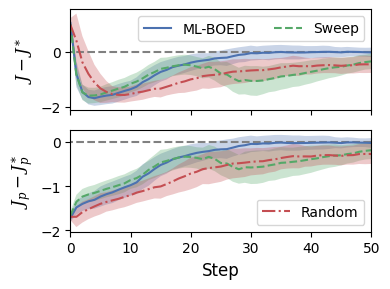

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(4, 3), sharex=True)    

ax = axes[0]
ax.hlines(0, -10, 60, linestyle='--', color='gray')
ax.plot(np.arange(51), difference_bay.mean(axis=0)[:,0], label='ML-BOED')
ax.fill_between(np.arange(51), difference_bay.mean(axis=0)[:,0] - difference_bay.std(axis=0)[:,0], difference_bay.mean(axis=0)[:,0] + difference_bay.std(axis=0)[:,0], alpha=0.3)
ax.plot(difference_seq.mean(axis=0)[:,0], '--', label='Sweep')
ax.fill_between(np.arange(51), difference_seq.mean(axis=0)[:,0] - difference_seq.std(axis=0)[:,0], difference_seq.mean(axis=0)[:,0] + difference_seq.std(axis=0)[:,0], alpha=0.3)
ax.plot(difference_rdn.mean(axis=0)[:,0], '-.')
ax.fill_between(np.arange(51), difference_rdn.mean(axis=0)[:,0] - difference_rdn.std(axis=0)[:,0], difference_rdn.mean(axis=0)[:,0] + difference_rdn.std(axis=0)[:,0], alpha=0.3)
ax.set_xlim([0, 50])
ax.set_ylabel(r'$J-J^{\ast}$')
ax.legend(loc='upper right', fontsize=10, ncol=2)

ax = axes[1]

ax.hlines(0, -10, 60, linestyle='--', color='gray')
ax.plot(difference_bay.mean(axis=0)[:,1])
ax.fill_between(np.arange(51), difference_bay.mean(axis=0)[:,1] - difference_bay.std(axis=0)[:,1], difference_bay.mean(axis=0)[:,1] + difference_bay.std(axis=0)[:,1], alpha=0.3)
ax.plot(difference_seq.mean(axis=0)[:,1], '--')
ax.fill_between(np.arange(51), difference_seq.mean(axis=0)[:,1] - difference_seq.std(axis=0)[:,1], difference_seq.mean(axis=0)[:,1] + difference_seq.std(axis=0)[:,1], alpha=0.3)
ax.plot(difference_rdn.mean(axis=0)[:,1], '-.', label='Random')
ax.fill_between(np.arange(51), difference_rdn.mean(axis=0)[:,1] - difference_rdn.std(axis=0)[:,1], difference_rdn.mean(axis=0)[:,1] + difference_rdn.std(axis=0)[:,1], alpha=0.3)
ax.set_xlim([0, 50])
ax.set_xlabel('Step')
ax.set_ylabel(r'$J_{p}-J_{p}^{\ast}$')
ax.set_yticks([-2, -1, 0])
ax.legend(loc='lower right', fontsize=10, ncol=2)

fig.align_ylabels(axes)
fig.tight_layout()
fig.savefig('figures/bay_seq_rdn_comparison.pdf', bbox_inches='tight')